## Mount my Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


## Imports

In [2]:
!pip install tensorflow==2.8.0
!pip install keras==2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 110.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.0
    Uninstalling tensorboard-data-server-0.7.0:
      Successfully uninstalled tensorboard-data-server-0.7.0
  Attempting uninstall: google-auth-oauthlib
    F

In [3]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2

In [4]:
dataset_dir = '/content/drive/MyDrive/Bangkit Datasets/TF3 C3 W1 Data/'

## Visualization Utilities

In [5]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
  image_width = image.shape[1]
  image_height = image.shape[0]
  cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)

def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
  boxes_shape = boxes.shape
  if not boxes_shape:
    return
  if len(boxes_shape)!=2 or boxes_shape[1]!=4:
    raise ValueError('Input must be of size [N, 4]')
  for i in range(boxes_shape[0]):
    draw_bounding_box_on_image(image, boxes[i,1], boxes[i,0], boxes[i,3], boxes[i,2],
                               color[i], thickness)

def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
  draw_bounding_boxes_on_image(image, boxes, color, thickness)
  return image

In [6]:
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


# utility to display a row of digits with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)

      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])

      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

## Preprocess and Load the Dataset

In [7]:
def read_image_tfds(image, bbox):
  image = tf.cast(image, tf.float32)
  shape = tf.shape(image)

  factor_x = tf.cast(shape[1], tf.float32)
  factor_y = tf.cast(shape[0], tf.float32)

  image = tf.image.resize(image, (224,224,))

  image = image/127.5
  image -= 1

  bbox_list = [bbox[0] / factor_x , bbox[1] / factor_y, bbox[2] / factor_x ,
               bbox[3] / factor_y]
  return image, bbox_list

In [8]:
def read_image_with_shape(image, bbox):
    original_image = image

    image, bbox_list = read_image_tfds(image, bbox)

    return original_image, image, bbox_list

In [9]:
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x ,
                 bbox[0] * factor_y,
                 bbox[3] * factor_x,
                 bbox[2] * factor_y]
    return image, bbox_list

In [10]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)

    if N > 0:
        take_dataset = take_dataset.take(N)

    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())

    return (np.array(ds_images), np.array(ds_bboxes))

In [11]:
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)

    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []

    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)

tfds.core.DatasetInfo(
    name='caltech_birds2010',
    full_name='caltech_birds2010/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    data_path='/content/drive/MyDrive/Bangkit Datasets/TF3 C3 W1 Data/caltech_birds2010/0.1.1',
    file_format=tfrecord,
    download_size=659.14 MiB,
    dataset_size=659.64 MiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=200),
        'label_name': Text(shape=(),

<ipython-input-10-101de12309d2>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return (np.array(ds_images), np.array(ds_bboxes))


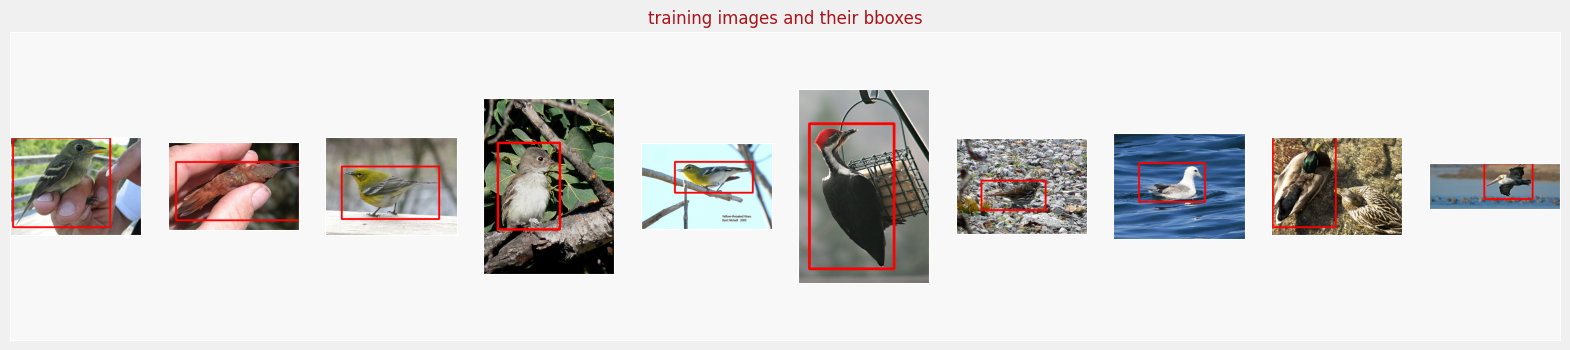

In [12]:
def get_visualization_training_dataset():
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=dataset_dir, download=False)
    print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox,
                                                 num_parallel_calls=16)
    return visualization_training_dataset


visualization_training_dataset = get_visualization_training_dataset()


(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")

<ipython-input-10-101de12309d2>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return (np.array(ds_images), np.array(ds_bboxes))


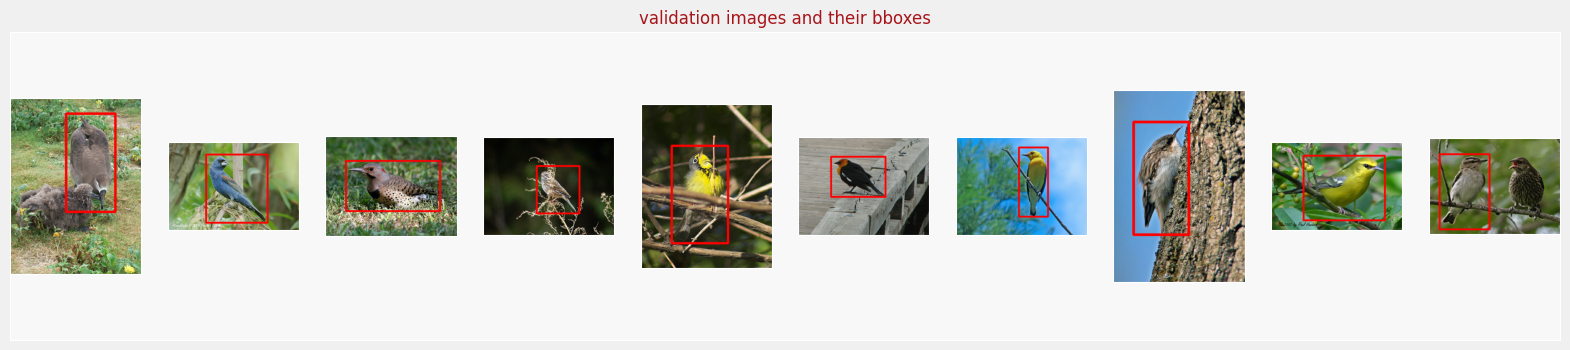

In [13]:
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", data_dir=dataset_dir, download=False)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset


visualization_validation_dataset = get_visualization_validation_dataset()

(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their bboxes")

In [14]:
BATCH_SIZE = 64

def get_training_dataset(dataset):
  dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
  dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(-1)

  return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

## Define the Network

In [15]:
def feature_extractor(inputs):
    mobilenet_model = tf.keras.applications.MobileNetV2(include_top=False,
                                                        input_shape=(224,224,3),
                                                        weights='imagenet')
    feature_extractor = mobilenet_model(inputs)

    return feature_extractor

In [16]:
def dense_layers(features):
    x = tf.keras.layers.GlobalAveragePooling2D()(features)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)

    return x

In [17]:
def bounding_box_regression(x):
    bounding_box_regression_output = tf.keras.layers.Dense(4, name='bounding_box')(x)

    return bounding_box_regression_output

In [18]:
def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    last_dense_layer = dense_layers(feature_cnn)
    bounding_box_output = bounding_box_regression(last_dense_layer)

    model = tf.keras.Model(inputs=inputs, outputs=bounding_box_output)

    return model

In [19]:
def define_and_compile_model():
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    model = final_model(inputs)
    model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),
                  loss='mse',
                  metrics='acc')
    return model

In [20]:
model = define_and_compile_model()
model.summary()

9420800/9406464 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                

## Train the Model

In [21]:
import math

EPOCHS = 50

BATCH_SIZE = 32

length_of_training_dataset = len(visualization_training_dataset)
length_of_validation_dataset = len(visualization_validation_dataset)

steps_per_epoch = math.ceil(length_of_training_dataset / BATCH_SIZE)

validation_steps = length_of_validation_dataset//BATCH_SIZE
if length_of_validation_dataset % BATCH_SIZE > 0:
    validation_steps += 1


In [22]:
history = model.fit(x=training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps,
                    epochs=EPOCHS)

Epoch 1/50
94/94 [==============================] - 90s 776ms/step - loss: 0.0505 - acc: 0.5741 - val_loss: 0.1859 - val_acc: 0.5143
Epoch 2/50
94/94 [==============================] - 68s 723ms/step - loss: 0.0115 - acc: 0.7078 - val_loss: 0.1387 - val_acc: 0.5375
Epoch 3/50
94/94 [==============================] - 68s 723ms/step - loss: 0.0076 - acc: 0.7650 - val_loss: 0.1027 - val_acc: 0.5517
Epoch 4/50
94/94 [==============================] - 68s 729ms/step - loss: 0.0057 - acc: 0.7965 - val_loss: 0.0814 - val_acc: 0.5675
Epoch 5/50
94/94 [==============================] - 67s 717ms/step - loss: 0.0049 - acc: 0.8125 - val_loss: 0.0714 - val_acc: 0.5696
Epoch 6/50
94/94 [==============================] - 67s 715ms/step - loss: 0.0042 - acc: 0.8356 - val_loss: 0.0610 - val_acc: 0.5799
Epoch 7/50
94/94 [==============================] - 67s 718ms/step - loss: 0.0038 - acc: 0.8452 - val_loss: 0.0475 - val_acc: 0.5875
Epoch 8/50
94/94 [==============================] - 67s 719ms/step - 

In [23]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

95/95 [==============================] - 29s 303ms/step - loss: 0.0151 - acc: 0.6312
Loss:  [0.015090701170265675, 0.6311869025230408]


In [24]:
model.save("birds.h5")

In [25]:
from google.colab import files

files.download("birds.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Validate

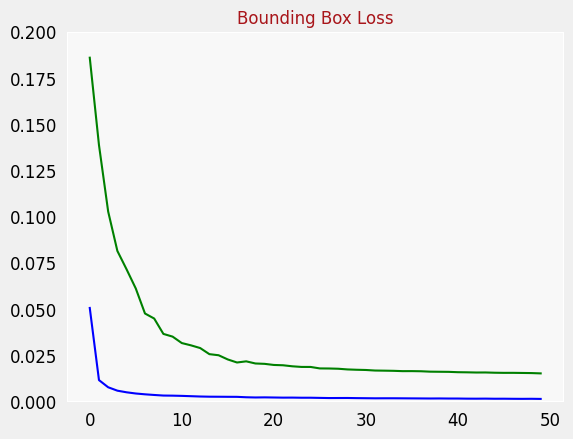

In [26]:
plot_metrics("loss", "Bounding Box Loss", ylim=0.2)

In [27]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

<ipython-input-11-0f92292fe070>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)


Number of predictions where iou > threshold(0.5): 280
Number of predictions where iou < threshold(0.5): 220


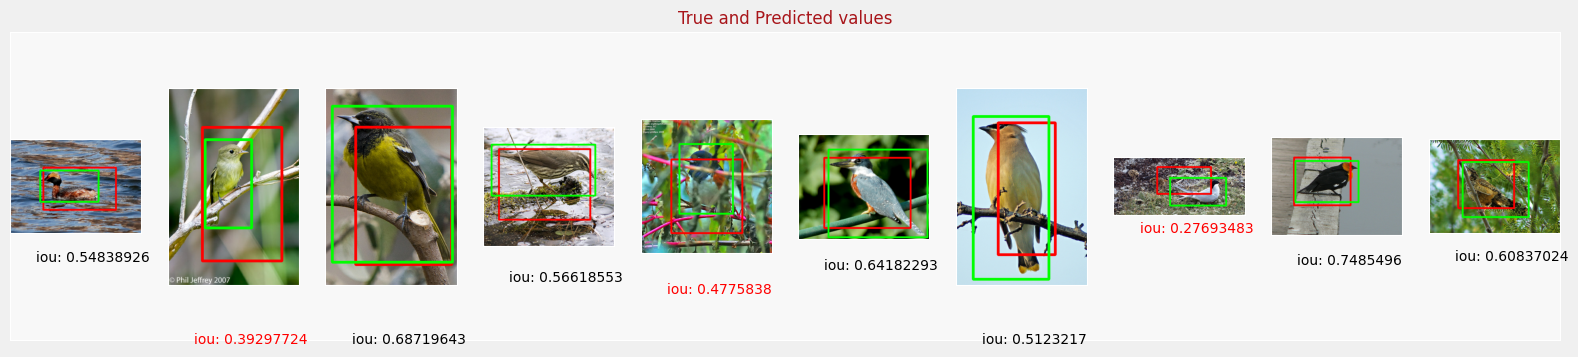

In [28]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)